In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import os
from ema_workbench import (MultiprocessingEvaluator, ema_logging, RealParameter, ScalarOutcome, Constant,
                           Model, HypervolumeMetric, save_results)
from ema_workbench.em_framework.optimization import (GenerationalBorg, epsilon_nondominated, to_problem, ArchiveLogger,
                                                     EpsilonProgress)

In [2]:
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\notebooks'

In [3]:
os.chdir('../runs')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs'

In [11]:
run_name = "debughv_20nfe_3seed"

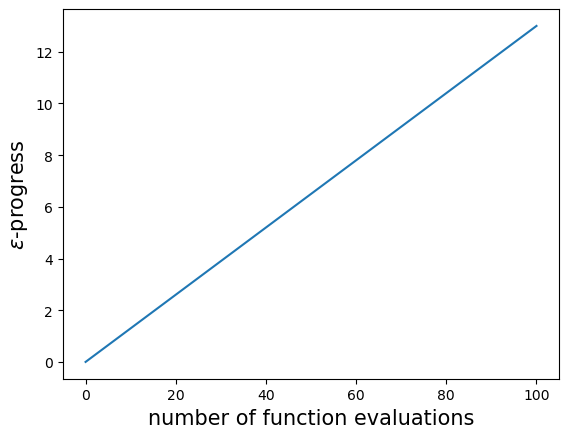

In [12]:
# Epsilon progress is already saved during the optimization
convergence = pd.read_csv(f"{run_name}/convergence1.csv") #ADD OTHER CONVERGENCES

fig, ax = plt.subplots()
ax.set_xlabel("number of function evaluations", fontsize=15)
ax.set_ylabel("$\epsilon$-progress", fontsize=15)
ax.plot(convergence.nfe, convergence.epsilon_progress)
plt.show()



In [13]:
convergence

,epsilon_progress,nfe
0,0,0
1,13,100


AttributeError: 'DataFrame' object has no attribute 'hypervolume'

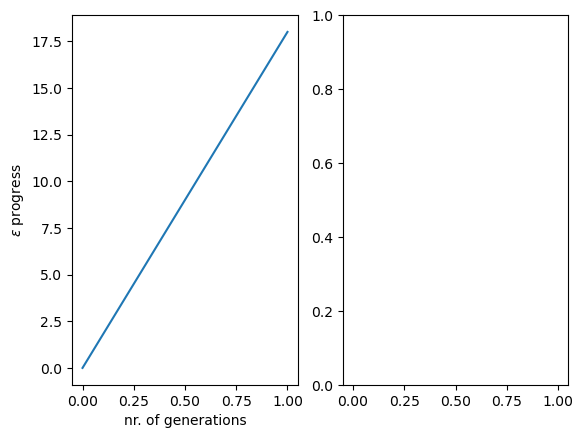

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)
ax1.plot(convergence.epsilon_progress)
ax1.set_xlabel('nr. of generations')
ax1.set_ylabel('$\epsilon$ progress')
ax2.plot(convergence.hypervolume)
ax2.set_ylabel('hypervolume')
sns.despine()
plt.show()

In [ ]:
obj_indexes = [-3, -2, -1]  # To get rid of Sudan objectives
directions = [
    "min",
    "min",
    "min",
]  # Only GERD Hydropower is a maximization objective
best = [
    1e9,
    1e9,
    1e9,
]  # Initialize the set of best values with really bad results (the aim is to reach the real best with the for loop)
worst = [0, 0, 0]  # Same idea, initialize the worst as something very good

listy = [1]
csvs_to_read = [f"{run_name}/archives/{i}.csv" for i in range(len(listy))]
csvs_to_read.append(
    f"{run_name}/results.csv"
)  # All archived solutions + final set

for file in csvs_to_read:
    print(file)
    current_df = pd.read_csv(file).iloc[:, obj_indexes]
    for i, col in enumerate(current_df.columns):
        # Updating the bests and worsts by looking at each solution:
        if directions[i] == "min":
            if current_df[col].max() > worst[i]:
                worst[i] = current_df[col].max()
            if current_df[col].min() < best[i]:
                best[i] = current_df[col].min()
        if directions[i] == "max":
            if current_df[col].max() > best[i]:
                best[i] = current_df[col].max()
            if current_df[col].min() < worst[i]:
                worst[i] = current_df[col].min()

In [ ]:
# Initialise the archives list
all_archives = []

# Load the archives
for i in range(2): # range(seeds)
    n=i+1
    archives = ArchiveLogger.load_archives(f"{run_name}/archives/{n}.csv")
    print("archive wihtin range:", archives)
    all_archives.append(archives)

#print(all_archives)

In [14]:
# Initialise the archives list
all_archives = []

# Load the archives
for i in range(2): # range(seeds)
    n=i+1
    archives = ArchiveLogger.load_archives(f"{run_name}/archives/{n}.csv")
    print("archive within range:", archives)
    print("type archives is:", type(archives))
    all_archives.append(archives)

print(all_archives)
'''
    # Define the problem
problem = to_problem(model, searchover="levers")
print('problem type is', type(problem))

# Define the reference list
reference_set = epsilon_nondominated(results_list, [0.8] * len(model.outcomes), problem) #[0.05]
print('reference_set', reference_set)
print('reference_set type is', type(reference_set))



reference_set = 
hv = HypervolumeMetric(reference_set, problem)

metrics_by_seed = []
for archives in all_archives:
    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "hypervolume": hv.calculate(archive),
            "nfe": int(nfe),
          }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    metrics_by_seed.append(metrics)
'''
'''
# Visualize convergence metrics
sns.set_style("white")
fig, axes = plt.subplots(nrows=2, figsize=(8, 12), sharex=True)

ax1, ax2 = axes

for metrics, convergence in zip(metrics_by_seed, convergences):
    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")
'''
'''

        ax3.plot(metrics.nfe, metrics.generational_distance)
        ax3.set_ylabel("generational distance")

        ax4.plot(metrics.nfe, metrics.epsilon_indicator)
        ax4.set_ylabel("epsilon indicator")

        ax5.plot(metrics.nfe, metrics.inverted_gd)
        ax5.set_ylabel("inverted generational\ndistance")

        ax6.plot(metrics.nfe, metrics.spacing)
        ax6.set_ylabel("spacing")

    # ax6.set_xlabel("nfe")

sns.despine(fig)

plt.show()
'''

archive within range: {0: Empty DataFrame
Columns: [Unnamed: 0, v0, v1, v2, v3, v4, v5, v6, v7, v8, v9, v10, v11, v12, v13, v14, v15, v16, v17, v18, v19, v20, v21, v22, v23, v24, v25, v26, v27, v28, v29, v30, v31, v32, v33, v34, v35, v36, v37, v38, v39, v40, v41, v42, v43, v44, v45, v46, v47, v48, v49, v50, v51, v52, v53, v54, v55, v56, v57, v58, v59, v60, v61, v62, v63, v64, v65, v66, v67, v68, v69, v70, v71, v72, v73, v74, v75, v76, v77, v78, v79, v80, v81, v82, v83, v84, v85, v86, v87, v88, v89, v90, v91, v92, v93, v94, v95, v96, v97, v98, ...]
Index: []

[0 rows x 234 columns], 100:    Unnamed: 0        v0        v1        v2        v3        v4        v5  \
0           0  0.707824  0.799298  0.137544  0.462704  0.544001  0.644855   
1           1 -0.051230 -0.003042 -0.528763 -0.176132 -0.355934  0.242874   
2           2  0.567866 -0.263503  0.967966 -0.773107  0.855955  0.734865   
3           3 -0.905887 -0.650200 -0.879758  0.680719 -0.035773  0.556416   
4           4 -0.2800

'\n\n        ax3.plot(metrics.nfe, metrics.generational_distance)\n        ax3.set_ylabel("generational distance")\n\n        ax4.plot(metrics.nfe, metrics.epsilon_indicator)\n        ax4.set_ylabel("epsilon indicator")\n\n        ax5.plot(metrics.nfe, metrics.inverted_gd)\n        ax5.set_ylabel("inverted generational\ndistance")\n\n        ax6.plot(metrics.nfe, metrics.spacing)\n        ax6.set_ylabel("spacing")\n\n    # ax6.set_xlabel("nfe")\n\nsns.despine(fig)\n\nplt.show()\n'

In [ ]:
    #############
    # CONVERGENCE #TODO: move to notebook
    #############

    # Change directory if needed
    if os.getcwd() != project_dir:
        print(f'Current directory is {os.getcwd()}')
        os.chdir(project_dir)
        print(f'Changed current directory to {project_dir}')

    # Initialise the archives list
    all_archives = []

    # Load the archives
    for i in range(seeds):
        archives = ArchiveLogger.load_archives(f"{archives_dir_path}/{i}.tar.gz")
        all_archives.append(archives)

    # Define the problem
    problem = to_problem(model, searchover="levers")
    print('problem type is', type(problem))

    # Define the reference list
    reference_set = epsilon_nondominated(results_list, [0.8] * len(model.outcomes), problem) #[0.05]
    print('reference_set', reference_set)
    print('reference_set type is', type(reference_set))


    hv = HypervolumeMetric(reference_set, problem)

    metrics_by_seed = []
    for archives in all_archives:
        metrics = []
        for nfe, archive in archives.items():
            scores = {
                "hypervolume": hv.calculate(archive),
                "nfe": int(nfe),
            }
            metrics.append(scores)
        metrics = pd.DataFrame.from_dict(metrics)

        # sort metrics by number of function evaluations
        metrics.sort_values(by="nfe", inplace=True)
        metrics_by_seed.append(metrics)

    # Visualize convergence metrics
    sns.set_style("white")
    fig, axes = plt.subplots(nrows=2, figsize=(8, 12), sharex=True)

    ax1, ax2 = axes

    for metrics, convergence in zip(metrics_by_seed, convergences):
        ax1.plot(metrics.nfe, metrics.hypervolume)
        ax1.set_ylabel("hypervolume")

        ax2.plot(convergence.nfe, convergence.epsilon_progress)
        ax2.set_ylabel("$\epsilon$ progress")

        '''
        ax3.plot(metrics.nfe, metrics.generational_distance)
        ax3.set_ylabel("generational distance")

        ax4.plot(metrics.nfe, metrics.epsilon_indicator)
        ax4.set_ylabel("epsilon indicator")

        ax5.plot(metrics.nfe, metrics.inverted_gd)
        ax5.set_ylabel("inverted generational\ndistance")

        ax6.plot(metrics.nfe, metrics.spacing)
        ax6.set_ylabel("spacing")
        '''

    # ax6.set_xlabel("nfe")

sns.despine(fig)

plt.show()


Hippo DAI lab

In [11]:
from platypus import Solution, Problem

# n_objs = 7
n_objs = 3

n_decision_vars = 230

problem = Problem(n_decision_vars, n_objs)

# matters for hypervolume
problem.directions[0] = Problem.MINIMIZE  # Total aggregated utility
problem.directions[1] = Problem.MINIMIZE  # Distance to threshold 2035
problem.directions[2] = Problem.MINIMIZE 

In [15]:
os.chdir('../src')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [17]:
df = pd.read_csv('metrics.csv', index_col = 0)
df

,hypervolume,nfe
0,0.000000,0
1,0.409179,100
